In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy.optimize as op

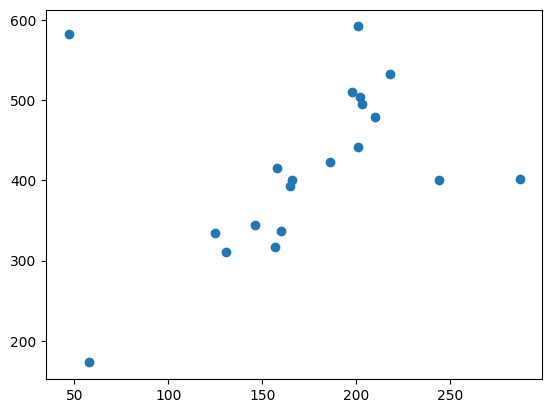

In [5]:
x = np.loadtxt("C:/Users/sandesh/Desktop/Mayu Software/Computational/Computational1/A4/data.txt",delimiter = '&',dtype = np.float64,comments = '#',usecols = 1)
y = np.loadtxt("C:/Users/sandesh/Desktop/Mayu Software/Computational/Computational1/A4/data.txt",delimiter = '&',dtype = np.float64,comments = '#',usecols = 2)
sigma = np.loadtxt("C:/Users/sandesh/Desktop/Mayu Software/Computational/Computational1/A4/data.txt",delimiter = '&',dtype = np.float64,comments = '#',usecols = 3)
plt.plot(x,y,'o')

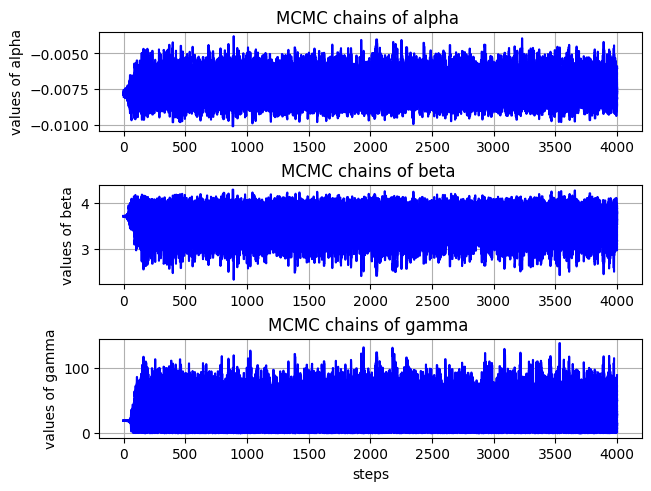

True values of parameters
alpha:  -0.007539586391716068
beta:  3.6207824793678287
gamma:  26.839808113340716
One-Sigma Values of parameters 16th and 84th Percentile:
alpha:  [-0.00822287 -0.00673231]
beta:  [3.3422023  3.83458462]
gamma:  [ 9.74352719 50.30817448]


C:\Users\sandesh\AppData\Local\Temp\ipykernel_14740\3758658394.py:80: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


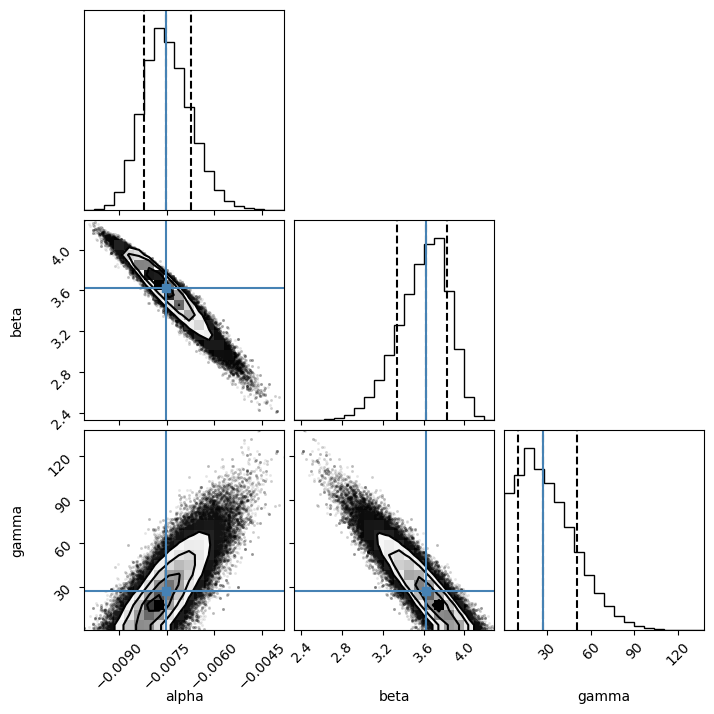

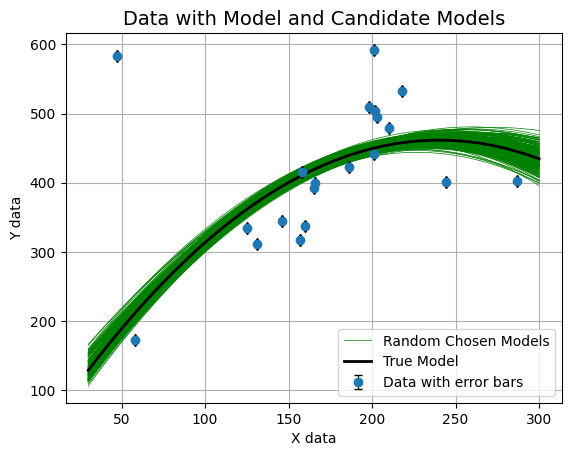

In [56]:
# Define the polynomial model using new variables
def f(x, args):
    alpha, beta, gamma = args
    return alpha * x**2.0 + beta * x + gamma

# Define the log likelihood function
def log_likelihood(data_params, x, y, yerr):
    alpha, beta, gamma = data_params
    model = f(x, data_params)
    sigma2 = yerr**2
    # Taking Gaussian Probability distribution to compute Likelihood
    return 0.5 * np.sum((y - model)**2 / sigma2 + np.log(2 * np.pi * sigma2))

# Define the log prior function (uniform priors)
def log_prior(data_params):
    alpha, beta, gamma = data_params
    # Taking uniform priors
    if (-200.0 < alpha < 200 and -500.0 < beta < 500.0 and 0 < gamma < 1000.0):
        return 0.0
    return -np.inf

# Define the log probability function
def log_probability(data_params, x, y, yerr):
    lp = log_prior(data_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_likelihood(data_params, x, y, yerr)

guess = (1.0, 1.0, 1.0)  # initial guess of the parameters

soln = op.minimize(log_likelihood, guess, args=(x_data, y_data, sigma_y))
nwalkers, ndim = 50, 3  # 50 MCMC chains 3 parameters
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_data, y_data, sigma_y))
sampler.run_mcmc(pos, 4000)  # 4000 MCMC runs per chain
samples = sampler.get_chain()

# Plotting MCMC chains of the parameters
fig = plt.figure(constrained_layout=True)
spec = fig.add_gridspec(3, 1)
p1 = fig.add_subplot(spec[0, 0])
p1.set_title("MCMC chains of alpha ")
p1.plot(samples[:, :, 0], color='blue')  # alpha values
p1.set_ylabel("values of alpha")
p1.grid()
p2 = fig.add_subplot(spec[1, 0])
p2.set_title("MCMC chains of beta ")
p2.plot(samples[:, :, 1], color='blue')  # beta values
p2.set_ylabel("values of beta")
p2.grid()
p3 = fig.add_subplot(spec[2, 0])
p3.set_title("MCMC chains of gamma ")
p3.plot(samples[:, :, 2], color='blue')  # gamma values
p3.set_xlabel("steps")
p3.set_ylabel("values of gamma")
p3.grid()
plt.show()

# Reshaping to incorporate all samples
sph = samples.shape
samples = np.reshape(np.ravel(samples), (sph[0] * sph[1], sph[2]))

# Computing Medians for true values
medians = np.median(samples, axis=0)
alpha_true, beta_true, gamma_true = medians
print("True values of parameters\nalpha: ", alpha_true)
print("beta: ", beta_true)
print("gamma: ", gamma_true)

# Calculating 1-Sigma values
one_sigma_vals_alpha = corner.quantile(samples[:, 0], q=[0.16, 0.84])
one_sigma_vals_beta = corner.quantile(samples[:, 1], q=[0.16, 0.84])
one_sigma_vals_gamma = corner.quantile(samples[:, 2], q=[0.16, 0.84])
print("One-Sigma Values of parameters 16th and 84th Percentile:\nalpha: ", one_sigma_vals_alpha)
print("beta: ", one_sigma_vals_beta)
print("gamma: ", one_sigma_vals_gamma)

# Plotting the Variations
fig2 = corner.corner(samples, labels=["alpha", "beta", "gamma"], quantiles=[0.16, 0.5, 0.84], truths=[alpha_true, beta_true, gamma_true])
fig2.show()
plt.show()

# Extracting 200 Data sets randomly
index = np.random.randint(0, sph[0] * sph[1] - 1, size=200)
model_param = np.zeros(shape=(200, 3), dtype=np.float64)
for i in range(len(index)):
    model_param[i] = samples[index[i]]
x = np.linspace(30.0, 300.0, 200)

# Plotting random models
for i in range(len(index)):
    if (i == 0):
        plt.plot(x, f(x, model_param[i]), color='green', lw=0.5, label='Random Chosen Models')
    else:
        plt.plot(x, f(x, model_param[i]), color='green', lw=0.5)

# Plotting the model with true parameters
plt.title("Data with Model and Candidate Models", size=14)
plt.plot(x, f(x, [alpha_true, beta_true, gamma_true]), color='black', lw=2, label="True Model")

# Plotting Data with error bars
plt.errorbar(x_data, y_data, yerr=sigma_y, fmt='o', ecolor='black', elinewidth=0.75, lolims=True, uplims=True, label="Data with error bars")
plt.grid()
plt.xlabel("X data")
plt.ylabel("Y data")
plt.legend()
plt.show()